In [1]:
#!pip install torch==1.2.0+cpu torchvision==0.4.0+cpu -f https://download.pytorch.org/whl/torch_stable.html
#!pip install plotly
import time
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
from plotly import tools
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, iplot_mpl
import os
import tensorflow as tf
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

c:\python37\lib\site-packages\tensorflow\python\fram

In [2]:
msft_data = pd.read_csv('MSFT.csv')
msft_data['Date'] = pd.to_datetime(msft_data['Date'])
msft_data = msft_data.set_index('Date')
msft_data = msft_data.drop(columns=["Close"])
msft_data.head()
#print(msft_data.index.min(), msft_data.index.max())

googl_data = pd.read_csv("GOOGL.csv")
googl_data['Date'] = pd.to_datetime(googl_data['Date'])
googl_data = googl_data.set_index('Date')
googl_data = googl_data.drop(columns=["Close"])
googl_data.head()

amzn_data = pd.read_csv("AMZN.csv")
amzn_data['Date'] = pd.to_datetime(amzn_data['Date'])
amzn_data = amzn_data.set_index('Date')
amzn_data = amzn_data.drop(columns=["Close"])
amzn_data.head()

ibm_data = pd.read_csv("IBM.csv")
ibm_data['Date'] = pd.to_datetime(ibm_data['Date'])
ibm_data = ibm_data.set_index('Date')
ibm_data = ibm_data.drop(columns=["Close"])
ibm_data.head()

aapl_data = pd.read_csv("AAPL.csv")
aapl_data['Date'] = pd.to_datetime(aapl_data['Date'])
aapl_data = aapl_data.set_index('Date')
aapl_data = aapl_data.drop(columns=["Close"])
aapl_data.head()

Open   High    Low  Adj Close     Volume
Date                                                 
2010-01-04  30.49  30.64  30.34      26.78  123432400
2010-01-05  30.66  30.80  30.46      26.83  150476200
2010-01-06  30.63  30.75  30.11      26.40  138040000
2010-01-07  30.25  30.29  29.86      26.35  119282800
2010-01-08  30.04  30.29  29.87      26.53  111902700

In [3]:
date_split = '2018-01-01'
msft_train, msft_test = msft_data[:date_split], msft_data[date_split:]
googl_train, googl_test = googl_data[:date_split], googl_data[date_split:]
amzn_train, amzn_test = amzn_data[:date_split], amzn_data[date_split:]
ibm_train, ibm_test = ibm_data[:date_split], ibm_data[date_split:]
aapl_train, aapl_test = aapl_data[:date_split], aapl_data[date_split:]

#len(train),len(test)

In [4]:
def plot_train_test(train, test, date_split):
    
    data = [
        Candlestick(x=train.index, open=train['Open'], high=train['High'], low=train['Low'], close=train['Adj Close'], name='train'),
        Candlestick(x=test.index, open=test['Open'], high=test['High'], low=test['Low'], close=test['Adj Close'], name='test')
    ]
    layout = {
         'shapes': [
             {'x0': date_split, 'x1': date_split, 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper', 'line': {'color': 'rgb(0,0,0)', 'width': 1}}
         ],
        'annotations': [
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'left', 'text': ' test data'},
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'right', 'text': 'train data '}
        ]
    }
    figure = Figure(data=data, layout=layout)
    iplot(figure)

In [5]:
print("Microsoft (MSFT)")
plot_train_test(msft_train, msft_test, date_split)

print("Google (GOOGL)")
plot_train_test(googl_train, googl_test, date_split)

print("Amazon (AMZN)")
plot_train_test(amzn_train, amzn_test, date_split)

print("IBM (IBM)")
plot_train_test(ibm_train, ibm_test, date_split)

print("Apple (AAPL)")
plot_train_test(aapl_train, aapl_test, date_split)


Microsoft (MSFT)


Google (GOOGL)


Amazon (AMZN)


IBM (IBM)


Apple (AAPL)


In [6]:
class Environment1:
    
    def __init__(self, data, history_t=90):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # obs
    
    def step(self, act):
        reward = 0
        
        # print(act)
        
        # act = 0: stay, 1: buy, 2: sell
        if act == 1: # buy
            self.positions.append(self.data.iloc[self.t, :]['Adj Close'])
        elif act == 2: # sell
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['Adj Close'] - p)
                reward += profits
                self.profits += profits
                self.positions = []
        
        # set next time
        self.t += 1
        
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Adj Close'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['Adj Close'] - self.data.iloc[(self.t-1), :]['Adj Close'])
        if (self.t==len(self.data)-1):
            self.done=True
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        #print ("t={%d}, done={%str}"%(self.t,self.done))
        return [self.position_value] + self.history, reward, self.done, self.data.iloc[self.t, :]['Adj Close'] # obs, reward, done
    

In [7]:
#def train_dqn(env):
    
class Q_Network(nn.Module):
        
    def __init__(self,obs_len,hidden_size,actions_n):
            
        super(Q_Network,self).__init__()
            
        self.fc_val = nn.Sequential(
            nn.Linear(obs_len, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, actions_n)
        )
        
        
    def forward(self,x):
        h =  self.fc_val(x)
        return (h)
            

In [8]:
epoch_num = 50 #50

memory_size = 30 #200
batch_size = 30 #50

def initialize_env(train):
    env = Environment1(train)

    hidden_size=100
    input_size=env.history_t+1
    output_size=3
    USE_CUDA = False
    LR = 0.001

    Q = Q_Network(input_size, hidden_size, output_size)

    Q_ast = copy.deepcopy(Q)

    if USE_CUDA:
        Q = Q.cuda()
    optimizer = optim.Adam(list(Q.parameters()), lr=LR)

    step_max = len(env.data)-1
 
    obs, reward, done, _ = env.step(5)
    
    return env, Q, Q_ast, train, step_max, optimizer

In [9]:
def rl_train(env, Q, Q_ast, train, step_max, optimizer):
    start = time.time()
    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 5
    
    loss_function = nn.MSELoss()

    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0
   
        while not done and step < step_max:
            
            # select act
            pact = np.random.randint(3)
            if np.random.rand() > epsilon:
                pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
                pact = np.argmax(pact.data)
                pact = pact.numpy()
                   
            # act
            obs, reward, done, price = env.step(pact)
           
            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(torch.from_numpy(b_pobs))
                        q_ = Q_ast(torch.from_numpy(b_obs))
                        maxq = np.max(q_.data.numpy(),axis=1)
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                        Q.zero_grad()
                        loss = loss_function(q, target)
                        total_loss += loss.data.item()
                        loss.backward()
                        optimizer.step()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

                # epsilon
                if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                    epsilon -= epsilon_decrease

                # next step
                total_reward += reward
                pobs = obs
                step += 1
                total_step += 1

            total_rewards.append(total_reward)
            total_losses.append(total_loss)

            if (epoch+1) % show_log_freq == 0:
                log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
                log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
                elapsed_time = time.time()-start
                #print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
                start = time.time()
        print("Epoch:", epoch+1, " Reward:", total_reward, " Loss:", total_loss)
    print("")
    
    return Q, total_losses, total_rewards
    

In [10]:
def calc_profits(Q, test, stock):
    test_env = Environment1(test)
    pobs = test_env.reset()
    test_acts = []
    test_rewards = []

    prices = []
    actions = []
    for _ in range(len(test_env.data)-1):

        pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
        pact = np.argmax(pact.data)
        test_acts.append(pact.item())
        
        obs, reward, done, price = test_env.step(pact.numpy())
        test_rewards.append(reward)
        prices.append(price)
        actions.append(pact)

        pobs = obs
    
    sess = tf.InteractiveSession()
    actions = [act.item() for act in actions]
    # Other ops
    sess.close()
    
    colors = []
    for a in actions:
        if a == 1:
            colors.append("#00ff00")
        elif a == 2:
            colors.append("#ff0000")
        else:
            colors.append("#ffffff00")
         
    
    plt.figure()
    plt.plot(prices)
    plt.scatter(np.arange(0, len(actions)), prices,c=colors)
    plt.title("Actual Prices " + stock)
    plt.ylabel("Price")
    plt.xlabel("Days")
    plt.legend()
    plt.savefig(stock + '_RL_actions.png')
    plt.show()
    
    start = 0
    end = start+len(actions)//8
    for i in range(8):
        plt.figure()
        plt.plot(prices[start:end])
        plt.scatter(np.arange(0, len(actions[start:end])), prices[start:end],c=colors[start:end])
        plt.title("Actual Prices " + stock + " Days " +str(start) + "-" + str(end))
        plt.ylabel("Price")
        plt.xlabel("Days")
        plt.legend()
        plt.savefig(stock + '_RL_actions_' + str(start) + "-" + str(end) + '.png');
        start += len(actions)//8
        end += len(actions)//8

    test_profits = test_env.profits
    return test_profits

In [11]:
def run_rl(train):
    env, Q, Q_ast, train_new, step_max, optimizer = initialize_env(train)
    Q_, total_losses, total_rewards = rl_train(env, Q, Q_ast, train, step_max, optimizer)
    return Q_

In [12]:
def get_profits(retrain=False):
    data = [(msft_train, msft_test, "MSFT"), 
                     (googl_train, googl_test, "GOOGL"), 
                     (amzn_train, amzn_test, "AMZN"),
                     (ibm_train, ibm_test, "IBM"),
                     (aapl_train, aapl_test, "AAPL")] 
    profits = []
    for train, test, stock in data:
        if retrain:
            Q_ = run_rl(train)
            pickle.dump(Q_, open(stock +"_rl.h5", "wb"))
        else:
            Q_ = pickle.load(open(stock+"_rl.h5", "rb"))
        
        profits.append((calc_profits(Q_, test, stock), stock))
    return profits     

Epoch: 1  Reward: -72.0  Loss: 37.97598625533283
Epoch: 2  Reward: 49.0  Loss: 16.080644017318264
Epoch: 3  Reward: 99.0  Loss: 15.413912943797186
Epoch: 4  Reward: 108  Loss: 13.663536670152098
Epoch: 5  Reward: 94.0  Loss: 14.855993386358023
Epoch: 6  Reward: 88.0  Loss: 20.228254253044724
Epoch: 7  Reward: 131.0  Loss: 15.650894718244672
Epoch: 8  Reward: 123.0  Loss: 15.995912631973624
Epoch: 9  Reward: 164.0  Loss: 16.114428993314505
Epoch: 10  Reward: 143.0  Loss: 14.702398715075105
Epoch: 11  Reward: 176.0  Loss: 15.189245972782373
Epoch: 12  Reward: 188.0  Loss: 16.647465434856713
Epoch: 13  Reward: 160  Loss: 15.04443727992475
Epoch: 14  Reward: 221.0  Loss: 15.438973700627685
Epoch: 15  Reward: 166.0  Loss: 15.70018324162811
Epoch: 16  Reward: 197.0  Loss: 14.11910065356642
Epoch: 17  Reward: 176.0  Loss: 12.736454484052956
Epoch: 18  Reward: 212.0  Loss: 15.42810373660177
Epoch: 19  Reward: 219.0  Loss: 16.145626528188586
Epoch: 20  Reward: 208.0  Loss: 16.24062141776085
Epo

No handles with labels found to put in legend.


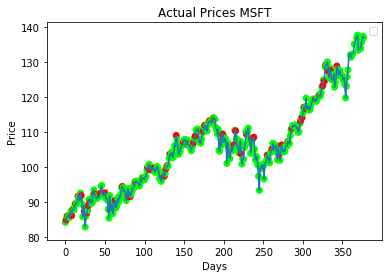

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Epoch: 1  Reward: -85  Loss: 3354.1895724609494
Epoch: 2  Reward: -62  Loss: 150.24639548361301
Epoch: 3  Reward: -54  Loss: 70.14690901711583
Epoch: 4  Reward: -33  Loss: 38.8657268313691
Epoch: 5  Reward: -9  Loss: 15.440422210842371
Epoch: 6  Reward: 1  Loss: 15.27489821985364
Epoch: 7  Reward: 18.0  Loss: 15.084071435965598
Epoch: 8  Reward: 40.0  Loss: 13.422874199226499
Epoch: 9  Reward: 34.0  Loss: 15.058046277612448
Epoch: 10  Reward: 30  Loss: 55.10618906375021
Epoch: 11  Reward: -4  Loss: 21.66977769136429
Epoch: 12  Reward: 6  Loss: 102.30221656663343
Epoch: 13  Reward: 32  Loss: 14.321846944279969
Epoch: 14  Reward: 41  Loss: 12.012041198089719
Epoch: 15  Reward: 60.0  Loss: 11.481758577283472
Epoch: 16  Reward: 65  Loss: 13.030248366296291
Epoch: 17  Reward: 83  Loss: 12.421829897910357
Epoch: 18  Reward: 83  Loss: 11.700261771678925
Epoch: 19  Reward: 71  Loss: 12.304605818353593
Epoch: 20  Reward: 58  Loss: 11.763089993502945
Epoch: 21  Reward: 80.0  Loss: 14.77718309964

No handles with labels found to put in legend.


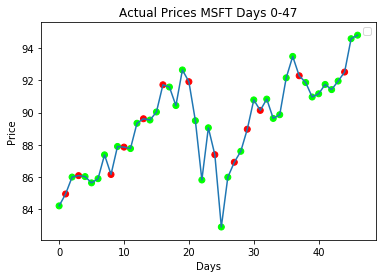

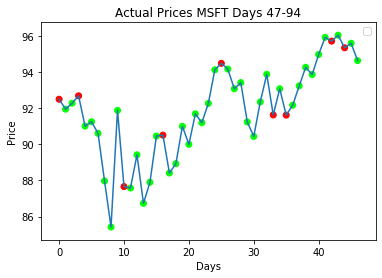

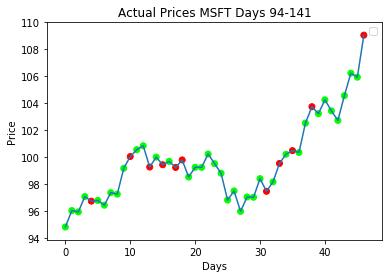

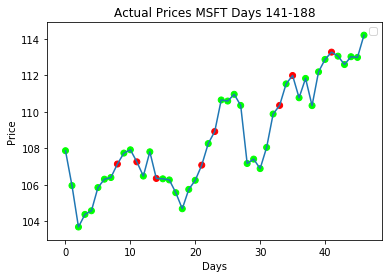

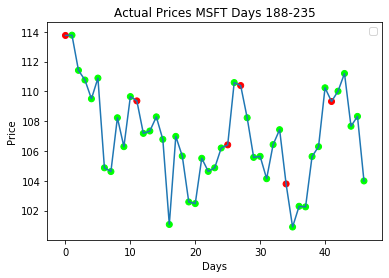

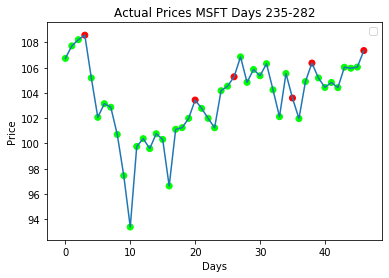

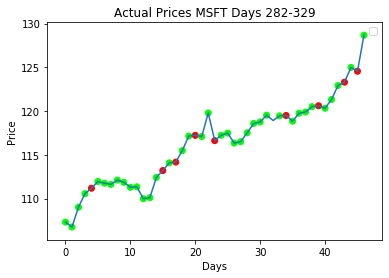

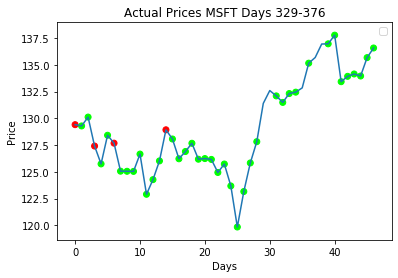

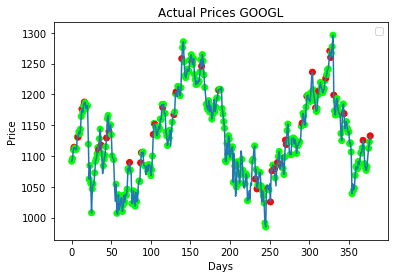

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Epoch: 1  Reward: -69  Loss: 7411.409537617117
Epoch: 2  Reward: -120  Loss: 101.13233071938157
Epoch: 3  Reward: -236  Loss: 64.99465318210423
Epoch: 4  Reward: 37  Loss: 17.900582682341337
Epoch: 5  Reward: 26  Loss: 17.5985618699342
Epoch: 6  Reward: 80  Loss: 17.827452306635678
Epoch: 7  Reward: 39  Loss: 65.63963623531163
Epoch: 8  Reward: 78  Loss: 16.218062915839255
Epoch: 9  Reward: 88  Loss: 15.620167047716677
Epoch: 10  Reward: 66  Loss: 14.335151678416878
Epoch: 11  Reward: 76  Loss: 20.462551912292838
Epoch: 12  Reward: 82  Loss: 19.46929071843624
Epoch: 13  Reward: 110  Loss: 19.028481179848313
Epoch: 14  Reward: 95  Loss: 20.169401165097952
Epoch: 15  Reward: 108  Loss: 17.889326494187117
Epoch: 16  Reward: 69.0  Loss: 23.95052931085229
Epoch: 17  Reward: 138.0  Loss: 19.324462877586484
Epoch: 18  Reward: 125.0  Loss: 26.3662319611758
Epoch: 19  Reward: 148  Loss: 21.803069239715114
Epoch: 20  Reward: 85  Loss: 23.86776733212173
Epoch: 21  Reward: 126  Loss: 22.0538449771

No handles with labels found to put in legend.


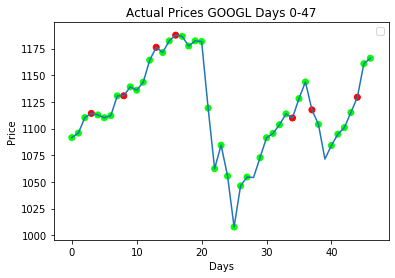

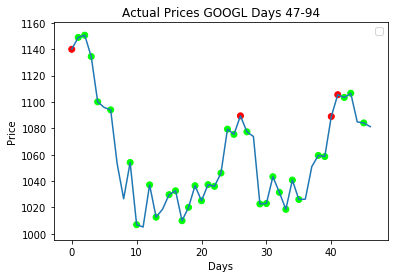

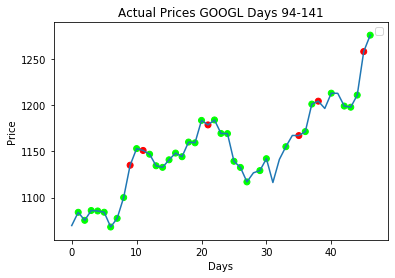

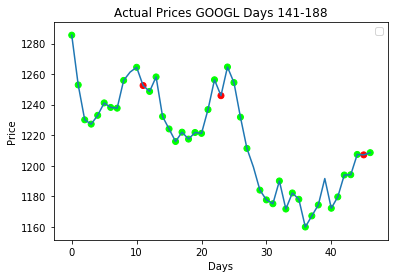

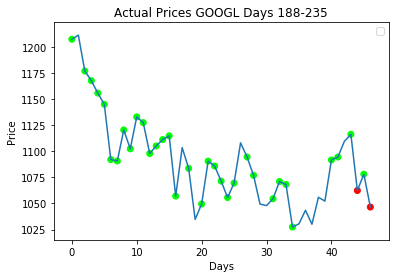

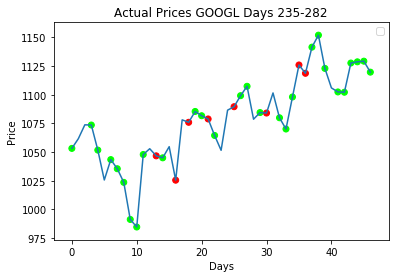

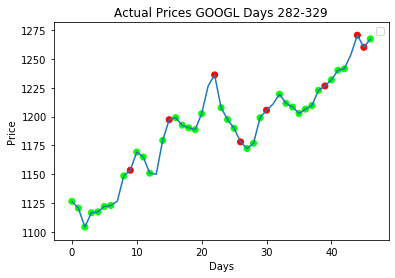

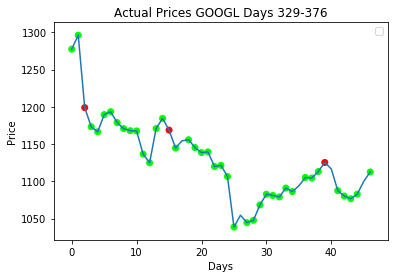

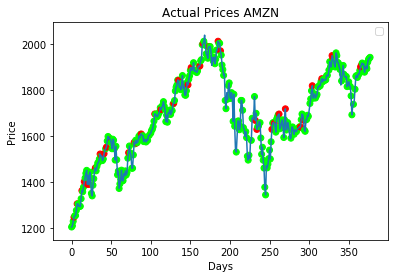

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Epoch: 1  Reward: -75.0  Loss: 28.937151128426194
Epoch: 2  Reward: 59  Loss: 24.941707658581436
Epoch: 3  Reward: 65.0  Loss: 12.873497946187854
Epoch: 4  Reward: 52  Loss: 9.525687366724014
Epoch: 5  Reward: 72.0  Loss: 17.62141154357232
Epoch: 6  Reward: 82  Loss: 15.561012155376375
Epoch: 7  Reward: 79.0  Loss: 15.093302516266704
Epoch: 8  Reward: 80  Loss: 12.228730656206608
Epoch: 9  Reward: 99.0  Loss: 12.964264980517328
Epoch: 10  Reward: 87.0  Loss: 11.374381794128567
Epoch: 11  Reward: 68  Loss: 10.005186936818063
Epoch: 12  Reward: 93  Loss: 12.860741247422993
Epoch: 13  Reward: 117  Loss: 17.09064777009189
Epoch: 14  Reward: 44  Loss: 10.456115587847307
Epoch: 15  Reward: 87  Loss: 11.277292056009173
Epoch: 16  Reward: 74  Loss: 12.553472068626434
Epoch: 17  Reward: 110  Loss: 12.03852002043277
Epoch: 18  Reward: 141  Loss: 16.928105318918824
Epoch: 19  Reward: 61  Loss: 15.669852619525045
Epoch: 20  Reward: 137  Loss: 12.983556906692684
Epoch: 21  Reward: 153.0  Loss: 14.8

No handles with labels found to put in legend.


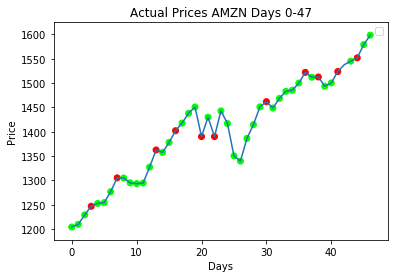

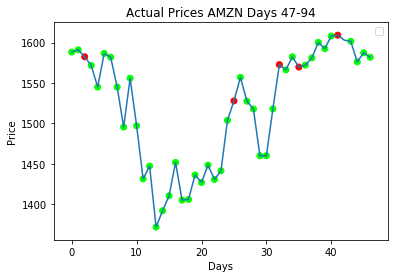

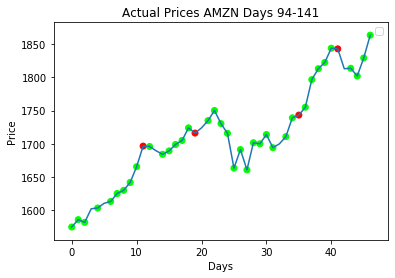

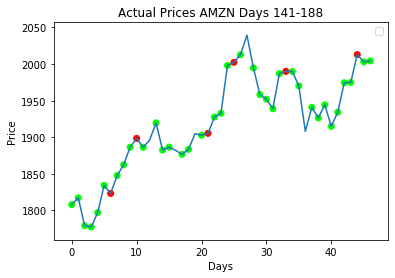

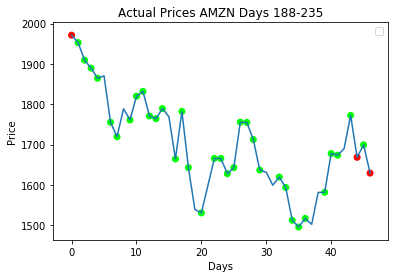

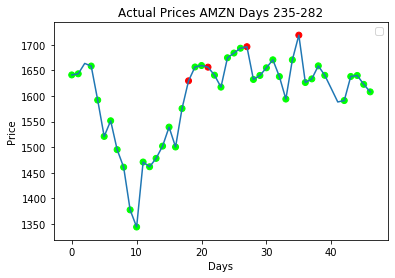

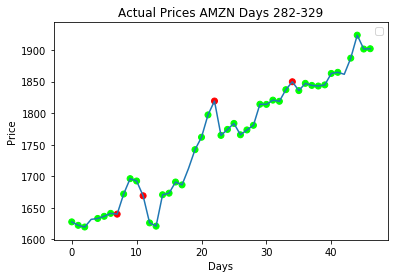

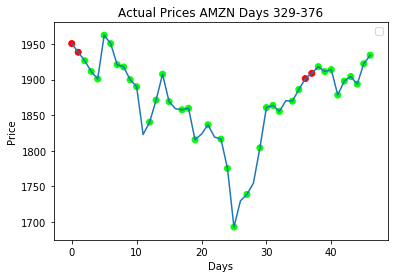

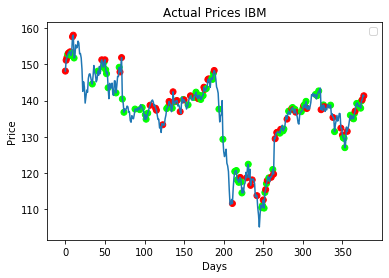

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Epoch: 1  Reward: -69  Loss: 606.6434264685959
Epoch: 2  Reward: 0  Loss: 15.061186554841697
Epoch: 3  Reward: 3  Loss: 10.582874299259856
Epoch: 4  Reward: 61  Loss: 11.514797648531385
Epoch: 5  Reward: 117  Loss: 20.543548695743084
Epoch: 6  Reward: 131  Loss: 19.505719212815166
Epoch: 7  Reward: 127  Loss: 19.78013886511326
Epoch: 8  Reward: 145  Loss: 42.60986829735339
Epoch: 9  Reward: 115  Loss: 38.7916375445202
Epoch: 10  Reward: 26  Loss: 29.603450403548777
Epoch: 11  Reward: 38  Loss: 36.35969170834869
Epoch: 12  Reward: 131  Loss: 16.075651295483112
Epoch: 13  Reward: 136  Loss: 16.62923967652023
Epoch: 14  Reward: 154  Loss: 18.884312391281128
Epoch: 15  Reward: 147.0  Loss: 16.956276459619403
Epoch: 16  Reward: 147.0  Loss: 19.35623300820589
Epoch: 17  Reward: 141.0  Loss: 14.098509101197124
Epoch: 18  Reward: 196.0  Loss: 20.99370458163321
Epoch: 19  Reward: 131.0  Loss: 15.219786122441292
Epoch: 20  Reward: 145.0  Loss: 17.64332501217723
Epoch: 21  Reward: 214.0  Loss: 23

No handles with labels found to put in legend.


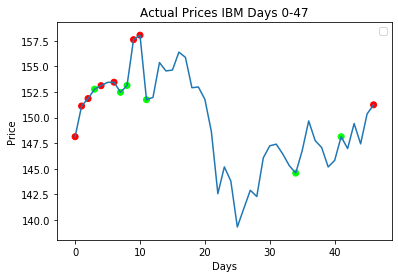

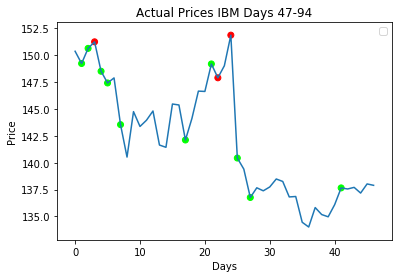

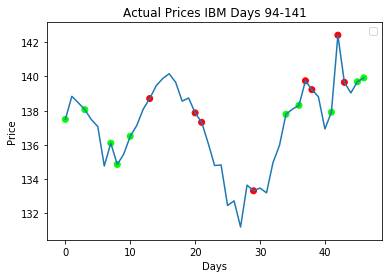

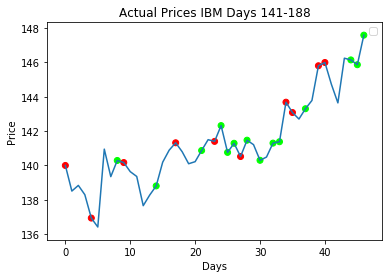

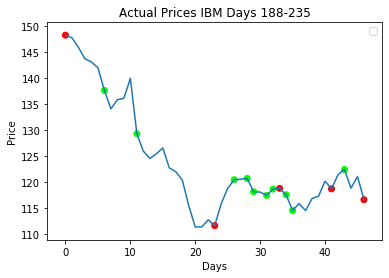

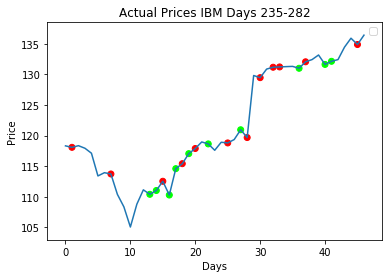

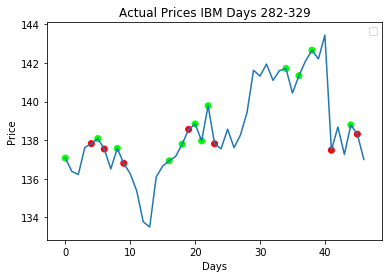

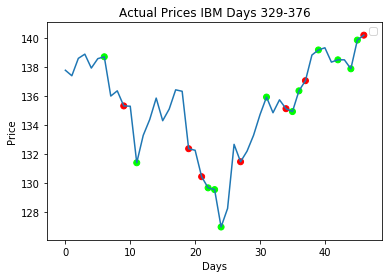

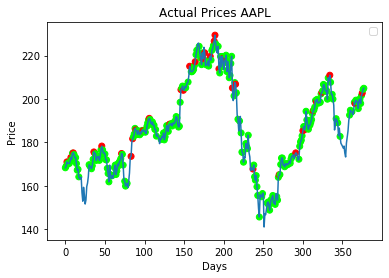

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


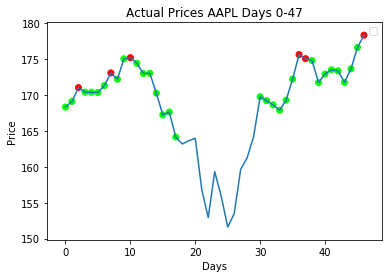

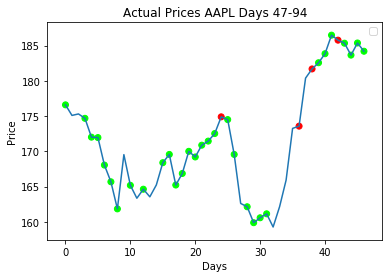

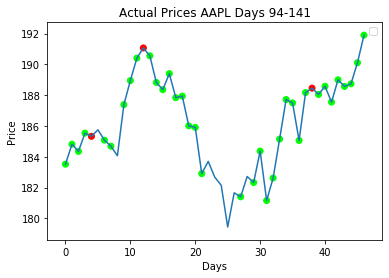

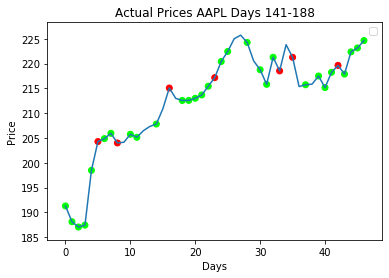

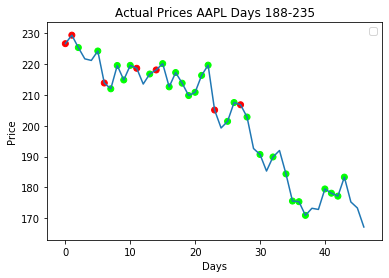

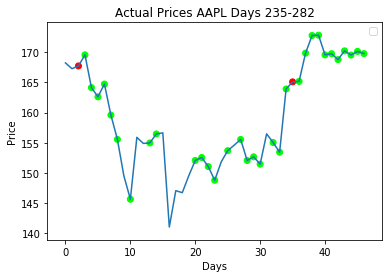

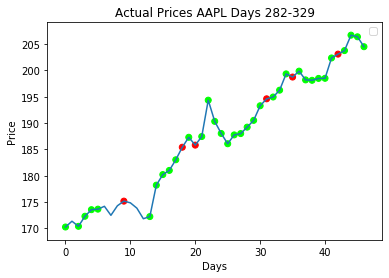

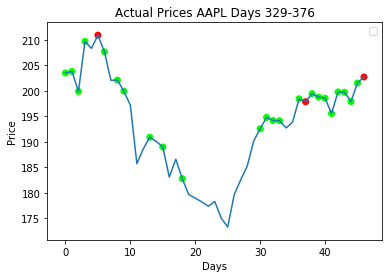

In [13]:
profits = get_profits(True)

In [14]:
print(profits)

[(374.49000000000007, 'MSFT'), (4446.129999999996, 'GOOGL'), (10460.879999999997, 'AMZN'), (16.54999999999984, 'IBM'), (755.2299999999996, 'AAPL')]


In [15]:
profits

[(374.49000000000007, 'MSFT'),
 (4446.129999999996, 'GOOGL'),
 (10460.879999999997, 'AMZN'),
 (16.54999999999984, 'IBM'),
 (755.2299999999996, 'AAPL')]